CaS: Carcinoma Squamous (Oral Squamous Cell Carcinoma – OSCC)

CoS: Condyloma Squamous or Cystic lesion (verify in dataset)

Gum: Gingiva (normal gum tissue)

MC: Mucocele (salivary gland cyst)

OC: Oral Cancer

OLP: Oral Lichen Planus

OT: Oral Thrush (Candidiasis)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.ndimage
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import os
import random

seed_value = 42

os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



In [3]:
df_train = pd.read_pickle('Pickles/df_train.pkl')
df_test = pd.read_pickle('Pickles/df_test.pkl')
df_val = pd.read_pickle('Pickles/df_val.pkl')

print("Train DataFrame shape:", df_train.shape)
print(df_train.head())

print("Test DataFrame shape:", df_test.shape)
print(df_test.head())

print("Validation DataFrame shape:", df_val.shape)
print(df_val.head())


Train DataFrame shape: (3087, 2)
                                               image label
0  [[[252, 217, 197], [252, 217, 197], [252, 217,...   CaS
1  [[[253, 216, 197], [252, 215, 196], [252, 215,...   CaS
2  [[[255, 255, 239], [254, 255, 238], [254, 255,...   CaS
3  [[[255, 255, 235], [255, 255, 235], [255, 255,...   CaS
4  [[[230, 194, 168], [230, 194, 168], [230, 194,...   CaS
Test DataFrame shape: (1028, 2)
                                               image label
0  [[[232, 197, 169], [232, 197, 169], [232, 197,...   CaS
1  [[[11, 13, 12], [11, 13, 12], [11, 13, 12], [1...   CaS
2  [[[193, 143, 120], [197, 147, 124], [201, 151,...   CaS
3  [[[243, 187, 162], [242, 186, 161], [240, 184,...   CaS
4  [[[100, 47, 31], [101, 48, 32], [101, 48, 32],...   CaS
Validation DataFrame shape: (1028, 2)
                                               image label
0  [[[255, 241, 225], [255, 241, 225], [255, 242,...   CaS
1  [[[205, 159, 136], [205, 159, 136], [204, 158,...   CaS
2  [[[24, 18

In [4]:
print("Type of first image:", type(df_train['image'].iloc[0]))

Type of first image: <class 'numpy.ndarray'>


In [5]:
X_train = np.stack(df_train['image'].values)
X_val = np.stack(df_val['image'].values)
X_test = np.stack(df_test['image'].values)


print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (3087, 256, 256, 3)
X_val shape: (1028, 256, 256, 3)
X_test shape: (1028, 256, 256, 3)


In [6]:
def gaussian_denoise(img, sigma=1.0):
    """
    Applies Gaussian filter to a single image.

    Args:
        img: numpy array image (H, W, C)
        sigma: standard deviation for Gaussian kernel

    Returns:
        Denoised image as numpy array
    """
    denoised = scipy.ndimage.gaussian_filter(img, sigma=(sigma, sigma, 0))
    return denoised


In [7]:
X_train = np.array([gaussian_denoise(img, sigma=1) for img in X_train])
X_val = np.array([gaussian_denoise(img, sigma=1) for img in X_val])
X_test = np.array([gaussian_denoise(img, sigma=1) for img in X_test])

print("Denoising applied. Example pixel range:")
print("X_train min/max:", X_train.min(), X_train.max())

Denoising applied. Example pixel range:
X_train min/max: 0 255


In [8]:
def adjust_contrast_tf(img, factor=1.5):
    """
    Adjusts contrast using TensorFlow.

    Args:
        img: numpy array image (H, W, C), values in [0,1]
        factor: contrast adjustment factor. >1 increases contrast.

    Returns:
        Contrast-adjusted image as numpy array.
    """
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_adjusted = tf.image.adjust_contrast(img_tensor, factor)
    return img_adjusted.numpy()

In [9]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = np.array([adjust_contrast_tf(img, factor=1.5) for img in X_train])
X_val = np.array([adjust_contrast_tf(img, factor=1.5) for img in X_val])
X_test = np.array([adjust_contrast_tf(img, factor=1.5) for img in X_test])

print("X_train_norm min/max:", X_train.min(), X_train.max())
print("X_val_norm min/max:", X_val.min(), X_val.max())
print("X_test_norm min/max:", X_test.min(), X_test.max())


X_train_norm min/max: -0.4850188 1.3924758
X_val_norm min/max: -0.4827448 1.3899677
X_test_norm min/max: -0.48377925 1.3821495


In [10]:
def convert_to_grayscale_tf(img):
    """
    Converts RGB image to grayscale using TensorFlow.

    Args:
        img: numpy array image (H, W, C), values in [0,1]

    Returns:
        Grayscale image with shape (H, W, 1), values in [0,1]
    """
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    gray = tf.image.rgb_to_grayscale(img_tensor)
    return gray.numpy()

In [11]:
X_train = np.array([convert_to_grayscale_tf(img) for img in X_train])
X_val = np.array([convert_to_grayscale_tf(img) for img in X_val])
X_test = np.array([convert_to_grayscale_tf(img) for img in X_test])

print("Grayscale conversion applied. Shapes:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

Grayscale conversion applied. Shapes:
X_train shape: (3087, 256, 256, 1)
X_val shape: (1028, 256, 256, 1)
X_test shape: (1028, 256, 256, 1)


In [12]:
le = LabelEncoder()

y_train = le.fit_transform(df_train['label'])
y_val = le.transform(df_val['label'])
y_test = le.transform(df_test['label'])

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print("y_train_cat shape:", y_train.shape)
print("y_val_cat shape:", y_val.shape)
print("y_test_enc shape:", y_test.shape)
print("Classes:", le.classes_)

y_train_cat shape: (3087, 7)
y_val_cat shape: (1028, 7)
y_test_enc shape: (1028, 7)
Classes: ['CaS' 'CoS' 'Gum' 'MC' 'OC' 'OLP' 'OT']


In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8,1.2]
)

In [14]:
target_size = (224, 224)

X_train = resize(X_train, target_size).numpy()
X_val = resize(X_val, target_size).numpy()
X_test = resize(X_test, target_size).numpy()

print("X_train_resized shape:", X_train.shape)
print("X_val_resized shape:", X_val.shape)
print("X_test_resized shape:", X_test.shape)

X_train_resized shape: (3087, 224, 224, 1)
X_val_resized shape: (1028, 224, 224, 1)
X_test_resized shape: (1028, 224, 224, 1)


In [15]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [16]:
input_shape = X_train.shape[1:]  
num_classes = y_train.shape[1]

print("Input shape:", input_shape)
print("Number of classes:", num_classes)

Input shape: (224, 224, 1)
Number of classes: 7


In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [18]:
def build_architecture_1(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_architecture_2(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

def build_architecture_3(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(256, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


def build_architecture_4(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [18]:
architectures = [
    ("Arch1", build_architecture_1),
    ("Arch2", build_architecture_2),
    ("Arch3", build_architecture_3),
    ("Arch4", build_architecture_4)
]

learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

results = []


In [ ]:
for arch_name, build_fn in architectures:
    for lr in learning_rates:
        print(f"\nTraining {arch_name} with learning rate: {lr}")

        model = build_fn(input_shape, num_classes)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=32),
            validation_data=(X_val, y_val),
            epochs=30,
            callbacks=[early_stop],
            verbose=2
        )

        final_val_acc = history.history['val_accuracy'][-1]
        results.append((arch_name, lr, final_val_acc))
        print(f"Finished {arch_name} with lr={lr}, final val_accuracy={final_val_acc:.4f}")


In [20]:
print("\n🔬 All Architecture + Learning Rate Results:")
for arch, lr, acc in results:
    print(f"Architecture: {arch}, Learning rate: {lr}, Validation Accuracy: {acc:.4f}")

best = max(results, key=lambda x: x[2])
print(f"\nBest model: {best[0]} with learning rate {best[1]} achieving validation accuracy {best[2]:.4f}")



🔬 All Architecture + Learning Rate Results:
Architecture: Arch1, Learning rate: 1e-05, Validation Accuracy: 0.1722
Architecture: Arch1, Learning rate: 5e-05, Validation Accuracy: 0.1449
Architecture: Arch1, Learning rate: 0.0001, Validation Accuracy: 0.1449
Architecture: Arch1, Learning rate: 0.0005, Validation Accuracy: 0.1449
Architecture: Arch1, Learning rate: 0.001, Validation Accuracy: 0.1479
Architecture: Arch2, Learning rate: 1e-05, Validation Accuracy: 0.4202
Architecture: Arch2, Learning rate: 5e-05, Validation Accuracy: 0.5000
Architecture: Arch2, Learning rate: 0.0001, Validation Accuracy: 0.6284
Architecture: Arch2, Learning rate: 0.0005, Validation Accuracy: 0.8064
Architecture: Arch2, Learning rate: 0.001, Validation Accuracy: 0.8249
Architecture: Arch3, Learning rate: 1e-05, Validation Accuracy: 0.1673
Architecture: Arch3, Learning rate: 5e-05, Validation Accuracy: 0.1576
Architecture: Arch3, Learning rate: 0.0001, Validation Accuracy: 0.1839
Architecture: Arch3, Learni

Best arch is : Arch4 (build_architecture_4) with learning rate :  0.0005

In [19]:
model = build_architecture_4(input_shape, num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model.summary()

c:\Users\Remo\anaconda3\envs\CCV\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,830,023 (37.50 MB)

 Trainable params: 9,828,551 (37.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/30
97/97 - 142s - 1s/step - accuracy: 0.5928 - loss: 1.1381 - val_accuracy: 0.6770 - val_loss: 0.9446
Epoch 2/30
97/97 - 143s - 1s/step - accuracy: 0.6097 - loss: 1.0830 - val_accuracy: 0.6547 - val_loss: 0.9152
Epoch 3/30
97/97 - 142s - 1s/step - accuracy: 0.6385 - loss: 0.9966 - val_accuracy: 0.5574 - val_loss: 1.3380
Epoch 4/30
97/97 - 142s - 1s/step - accuracy: 0.6356 - loss: 1.0141 - val_accuracy: 0.4835 - val_loss: 1.6224
Epoch 5/30
97/97 - 142s - 1s/step - accuracy: 0.6744 - loss: 0.9140 - val_accuracy: 0.4767 - val_loss: 1.9939
Epoch 6/30
97/97 - 145s - 1s/step - accuracy: 0.6961 - loss: 0.8603 - val_accuracy: 0.5895 - val_loss: 1.3468
Epoch 7/30
97/97 - 141s - 1s/step - accuracy: 0.7156 - loss: 0.8092 - val_accuracy: 0.4961 - val_loss: 1.7503
Epoch 8/30
97/97 - 140s - 1s/step - accuracy: 0.7013 - loss: 0.8674 - val_accuracy: 0.5204 - val_loss: 1.9798


In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.7702 - loss: 0.6372
Test Loss: 0.8737525939941406
Test Accuracy: 0.6789883375167847


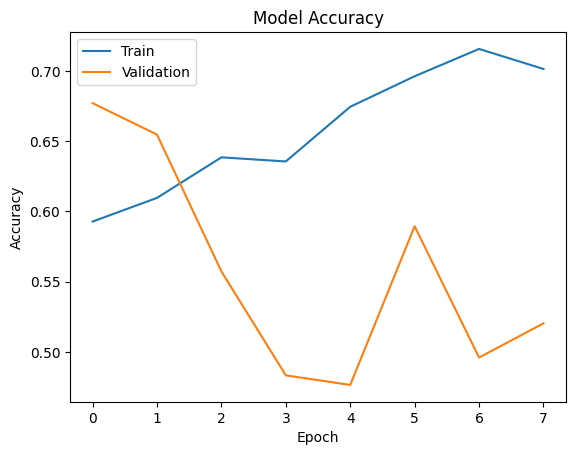

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

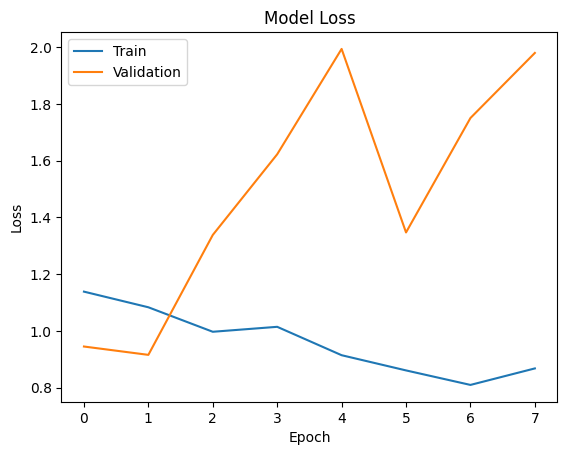

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save("Models/Arch_4_lr=0005.h5")